In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#from datetime import datetime, timedelta
import backtrader as bt
import quantstats
from collections import defaultdict
#Import my function library
import ipynb.fs.full.MRT_Funcs as MRT
#Import my strategy library
import ipynb.fs.full.BacktraderStrats as myStrats

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2018-03-08 ADA-CAD BUY EXECUTED, 0.32
2018-03-18 ETH-CAD BUY EXECUTED, 722.21
2018-04-20 ADA-CAD SELL EXECUTED, 0.34
2018-04-24 ETH-CAD SELL EXECUTED, 826.32
2018-05-24 ADA-CAD BUY EXECUTED, 0.26
2018-07-24 ADA-CAD SELL EXECUTED, 0.22
2018-08-12 ETH-CAD BUY EXECUTED, 421.56
2018-08-14 ADA-CAD BUY EXECUTED, 0.13
2018-11-21 BTC-CAD BUY EXECUTED, 5942.07
2018-12-30 ETH-CAD SELL EXECUTED, 187.66
2018-12-31 ADA-CAD SELL EXECUTED, 0.06
Starting Portfolio Value: 100.000000
Final Portfolio Value: 93.740982
PnL: -6.26


<IPython.core.display.Javascript object>


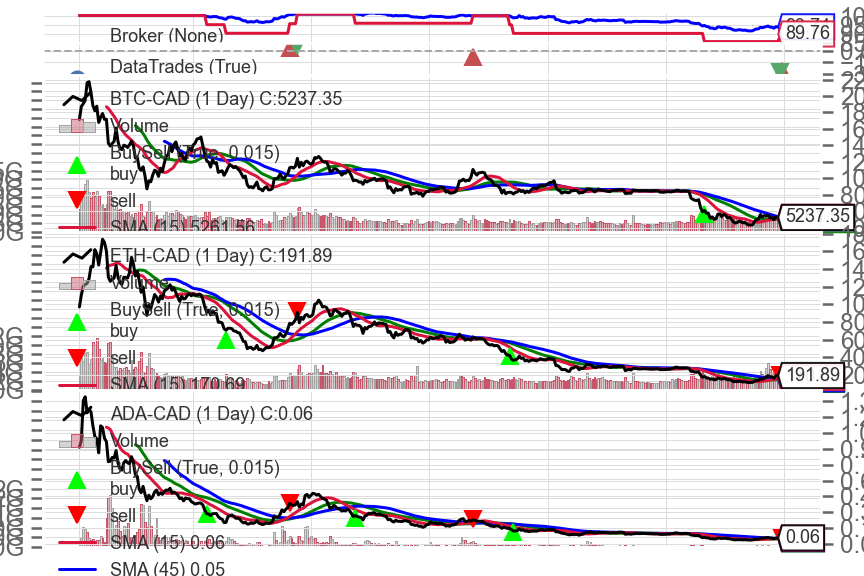

In [84]:
#Training set: cryptos valid back to 2018-01
#tickers = ['ADA-CAD','BAT-CAD','BCH-CAD','BTC-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MKR-CAD','XTZ-CAD','XLM-CAD','ZRX-CAD']
#Cryptos not in the training set
#tickers = ['AAVE-CAD','BAL-CAD','COMP-CAD','CRV-CAD','KNC-CAD','MATIC-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD']
#All cryptos:
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#Small dummy set:
tickers = ['BTC-CAD','ETH-CAD','ADA-CAD']
#tickers = ['AMZN','GOOGL','AAPL','SNP','TSLA','RACE']

start_date = '2018-01-01'
end_date = '2019-01-01'

tearsheet=False
stats=False
plot=True

#Strategy parameters
wshort = 15
wlong = 45
shortlongthresh=0.05
wext=30
extthresh=0.25

#Instantiate Cerebro engine
cerebro = bt.Cerebro()

#Add data feed to Cerebro
MRT.addPortfolioToFeed(tickers, cerebro, start_date, end_date)

#Add strategy to Cerebro
cerebro.addstrategy(myStrats.SMAdual, wshort=wshort, wlong=wlong, shortlongthresh=shortlongthresh, wext=wext, extthresh=extthresh)

#Default position size
cerebro.addsizer(bt.sizers.PercentSizer, percents = 5)

#Set broker cash initial value
cerebro.broker.set_cash(100) 

#Set broker commission rate
cerebro.broker.setcommission(commission=0.01)  # 1% of the operation value

#Add analyzers
if stats:
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
    cerebro.addanalyzer(bt.analyzers.Returns,     _name = "returns")
    cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")
if tearsheet:
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

#cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
#cerebro.addanalyzer(bt.analyzers.Returns,     _name = "returns")
#cerebro.addanalyzer(bt.analyzers.Transactions, _name = "trans")


if __name__ == '__main__':
    # Run Cerebro Engine
    start_portfolio_value = cerebro.broker.getvalue()

    results = cerebro.run()
    strat = results[0]

    end_portfolio_value = cerebro.broker.getvalue()
    pnl = end_portfolio_value - start_portfolio_value
    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl:.2f}')
    
    if stats:
        print(results[0].analyzers.returns.get_analysis()['rnorm100'])
        print(results[0].analyzers.sharpe.get_analysis())
        print(results[0].analyzers.trans.get_analysis())
    
    if plot:
        cerebro.plot()
    
    if tearsheet:
        portfolio_stats = strat.analyzers.getbyname('PyFolio')
        returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
        returns.index = returns.index.tz_convert(None)
        quantstats.reports.html(returns, output='backtrader_tearsheets/stats.html', title='quantstats test')